# Measuring Momentum
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie

Notebook released under the Creative Commons Attribution 4.0 License.

For background on momentum stratgies, please see the Momentum Strategies lecture. In this lecture we will talk about different ways to measure momentum more than how and why to use it.

In [1]:
from statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

##Moving Average Crossover

A very common way to obtain a momentum signal is to look for moving average crossovers. This means computing two moving averages of different lengths, and waiting for one to cross the other. The direction of the cross will indicate the direction of the momentum.

We'll demonstrate this on some real asset data.

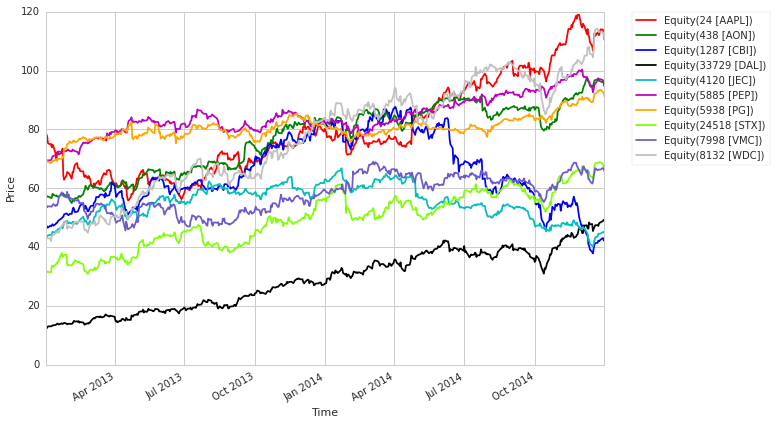

In [2]:
# Load some asset data
start = '2013-01-01'
end = '2015-01-01'
assets = sorted(['STX', 'WDC', 'CBI', 'JEC', 'VMC', 'PG', 'AAPL', 'PEP', 'AON', 'DAL'])
data = get_pricing(assets, start_date=start, end_date=end).loc['price', :, :]

# Plot the prices just for fun
data.plot(figsize=(10,7), color=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                  'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Price')
plt.xlabel('Time');

In [3]:
data.columns

Index([  Equity(24 [AAPL]),   Equity(438 [AON]),  Equity(1287 [CBI]),
       Equity(33729 [DAL]),  Equity(4120 [JEC]),  Equity(5885 [PEP]),
         Equity(5938 [PG]), Equity(24518 [STX]),  Equity(7998 [VMC]),
        Equity(8132 [WDC])],
      dtype='object')

In [4]:
asset = data.iloc[:, 8]

First we'll show the asset.

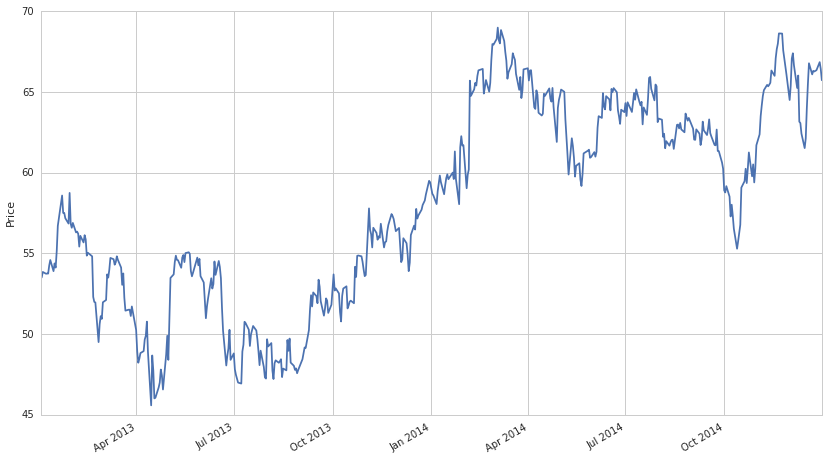

In [5]:
asset.plot()
plt.ylabel('Price')

Next we'll add a 30 day moving average and a 200 day moving average.

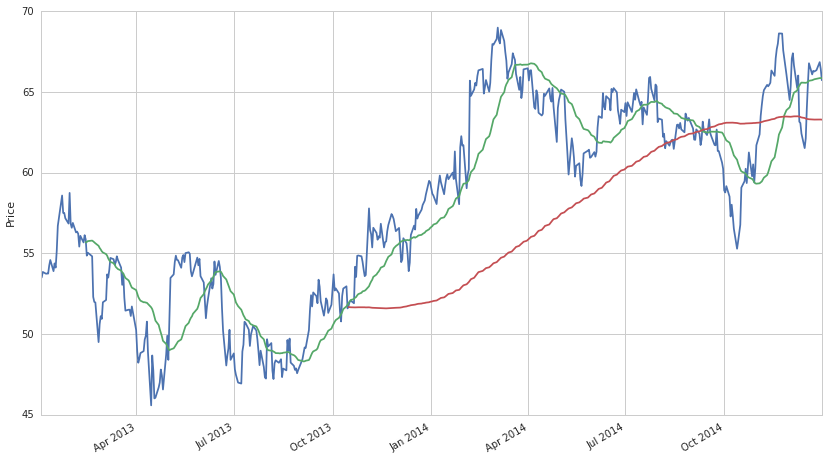

In [6]:
short_mavg = pd.rolling_mean(asset, 30)
long_mavg = pd.rolling_mean(asset, 200)

asset.plot()
short_mavg.plot()
long_mavg.plot()
plt.ylabel('Price')

We can see here that there are two crossing points once both averages are fully populated. The first does seem to be indicative of a following downturn, but the second occurs too close to the end of our data to be sure.

We will share some examples of moving average crossover strategies going forward, and many examples can be found in the forums.

###Choosing Moving Average Lengths

####WARNING: Overfitting

The choice of lengths will strongly affect the signal that you receive from your moving average crossover strategy. There may be better windows, and attempts to find them can be made with robust optimization techniques. However, it is incredibly easy to overfit your moving window lengths. For an exmaple of this see the Dangers of Overfitting lecture.



##Moving Average Crossover Ribbons

Another approach is to draw many moving averages at a time, and attempt to extract statistics from the shape of the 'ribbon' rather than any two moving averages. Let's see an example of this on the same asset.

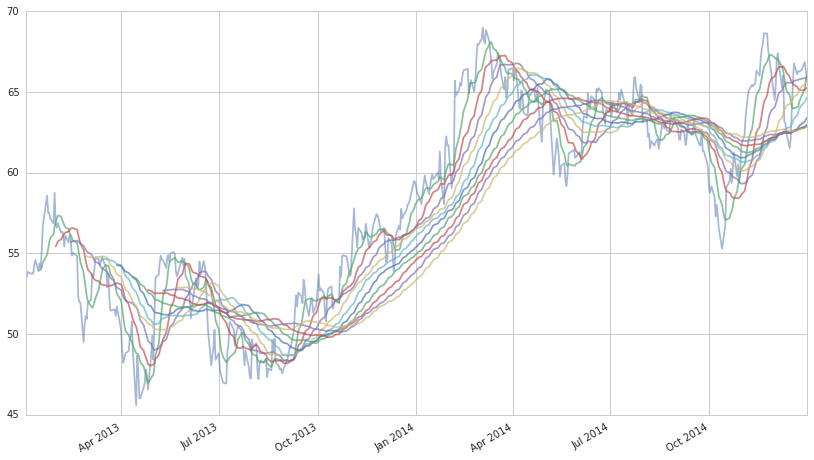

In [7]:
asset.plot(alpha = 0.5)

rolling_means = {}

for i in np.linspace(10, 100, 10):
    X = pd.rolling_mean(asset, i)
    rolling_means[i] = X
    X.plot(alpha = 0.7)
    
rolling_means = pd.DataFrame(rolling_means).dropna()

###Information About Ribbon Shape

Often this is more of a 'by-hand' enterprise, but we are more rigorous and would like to have a quantitative measure of ribbon shape. This will in turn give us a trading signal. Here are a few potential options.

####Distance Metric

We can use a distance metric to see how far away from some given ranking our ribbon is. Here we check against a 1-10 ranking. For more ideas on distance metrics, check out [this slide deck](http://theory.stanford.edu/~sergei/slides/www10-metrics.pdf).

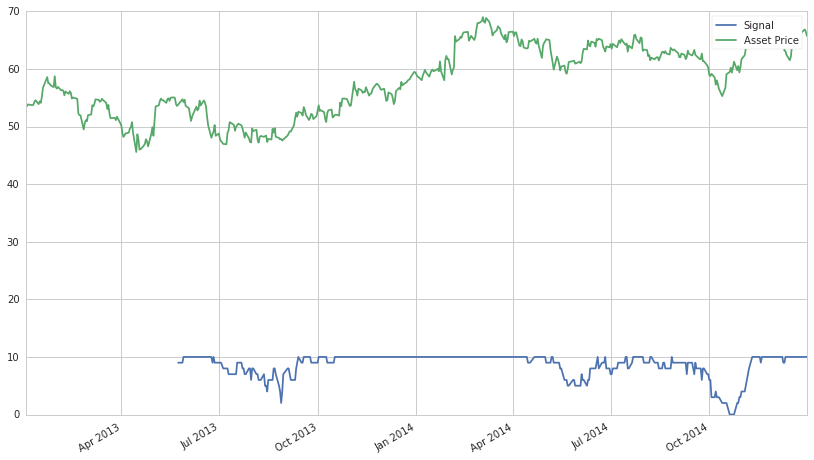

In [8]:
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)
    d = distance.hamming(ranking, range(1, 11))
    scores[date] = d
    
# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price']);

We can also use a correlation metric.

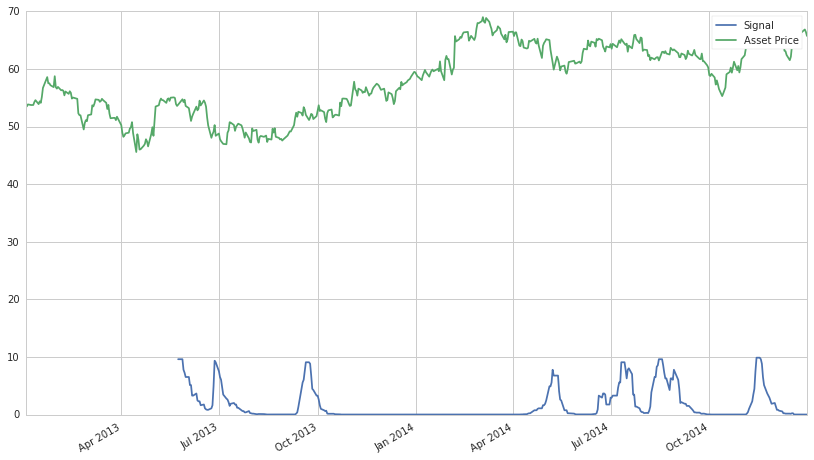

In [9]:
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)
    _, d = stats.spearmanr(ranking, range(1, 11))
    scores[date] = d

# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price']);

####Measuring Thickness

We can also just take the range of values at any given time to monitor the thickness of the ribbon.

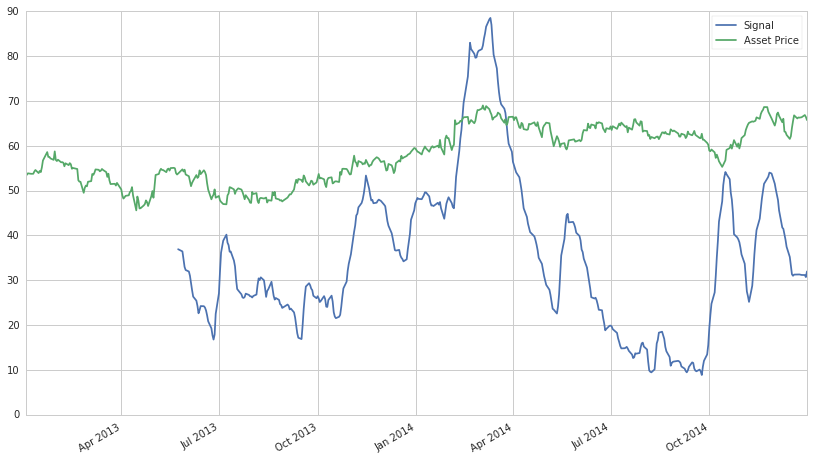

In [10]:
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    d = np.max(mavg_values) - np.min(mavg_values)
    scores[date] = d
    
# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price']);

##Measures of Momentum From Physics

Here we present some measures of momentum taken from physics. The paper describing these measures can be found here http://arxiv.org/pdf/1208.2775.pdf. The authors define 4 different measures, called $p^{(1)}$, $p^{(0)}$, $p^{(2)}$, and $p^{(3)}$.

Their approach is based in physics, where the momentum is defined as $p = mv$, the product of the mass and the velocity. First, they define $x(t)$ to be the log of the price of the security. Conveniently, the return on the security is then the derivative of $x(t)$, which is called the velocity $v(t)$. Then they suggest a number of different definitions of mass $m(t)$; in the examples below, we'll use the inverse of standard deviation and turnover rate as mass. This works with our analogy because the more volatile or the less liquid an asset (the smaller its mass), the easier it is to move its price (i.e. change its position). The different momenta are then defined (for a lookback window $k$) as:
$$p^{(0)}(t) = \sum_{i=0}^{k-1} v(t-i)$$
$$p^{(1)}(t) = \sum_{i=0}^{k-1} m(t-i) v(t-i)$$
$$p^{(2)}(t) = \frac{\sum_{i=0}^{k-1} m(t-i) v(t-i)}{\sum_{i=0}^{k-1} m(t-i)}$$
$$p^{(3)}(t) = \frac{\mu(v(t-k+1),\ldots, v(t))}{\sigma(v(t-k+1),\ldots, v(t))} $$

First, let's just implement the different momentum definitions, and plot the rolling momenta for one stock.

In [11]:
k = 30
start = '2014-01-01'
end = '2015-01-01'
pricing = get_pricing('PEP', fields='price', start_date=start, end_date=end)
fundamentals = init_fundamentals()
num_shares = get_fundamentals(query(fundamentals.earnings_report.basic_average_shares,)
                              .filter(fundamentals.company_reference.primary_symbol == 'PEP',), end)
x = np.log(pricing)
v = x.diff()
m = get_pricing('PEP', fields='volume', start_date=start, end_date=end)/num_shares.values[0,0]

p0 = pd.rolling_sum(v, k)
p1 = pd.rolling_sum(m*v, k)
p2 = p1/pd.rolling_sum(m, k)
p3 = pd.rolling_mean(v, k)/pd.rolling_std(v, k)

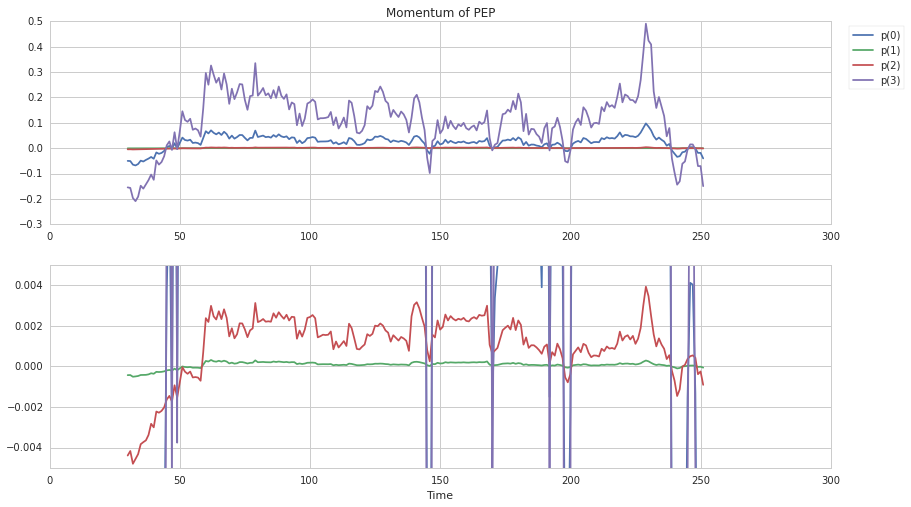

In [12]:
f, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(p0)
ax1.plot(p1)
ax1.plot(p2)
ax1.plot(p3)
ax1.set_title('Momentum of PEP')
ax1.legend(['p(0)', 'p(1)', 'p(2)', 'p(3)'], bbox_to_anchor=(1.1, 1))

ax2.plot(p0)
ax2.plot(p1)
ax2.plot(p2)
ax2.plot(p3)
ax2.axis([0, 300, -0.005, 0.005])
ax2.set_xlabel('Time');

###Code to Implement Physics Measures

Here are two piece of code to implement these momentum measures. The first computes the measures in a research environment using rolling computations. The second computes them in a backtesting environment when your data is already pared down to a fixed lookback window.

In [13]:
def get_p(prices, m, d, k):
    """ Returns the dth-degree rolling momentum of data using lookback window length k """
    x = np.log(prices)
    v = x.diff()
    m = np.array(m)
    
    if d == 0:
        return pd.rolling_sum(v, k)
    elif d == 1:
        return pd.rolling_sum(m*v, k)
    elif d == 2:
        return pd.rolling_sum(m*v, k)/pd.rolling_sum(m, k)
    elif d == 3:
        return pd.rolling_mean(v, k)/pd.rolling_std(v, k)
    
def backtest_get_p(prices, m, d):
    """ Returns the dth-degree rolling momentum of data"""
    v = np.diff(np.log(prices))
    m = np.array(m)
    
    if d == 0:
        return np.sum(v)
    elif d == 1:
        return np.sum(m*v)
    elif d == 2:
        return np.sum(m*v)/np.sum(m)
    elif d == 3:
        return np.mean(v)/np.std(v)

### Going forward

* What are good lookback and holding period lengths? We picked 30 days as a reasonable default but others might make more sense (or even different lengths for the different momentum definitions). Be careful not to overfit here!
* Try different definitions of mass. The paper suggests turnover rate and daily transaction value (and volatility is only used for $p^{(3)}$).

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*